<a href="https://colab.research.google.com/github/Saiee2508/DL-/blob/main/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 13.3 MB/s eta 0:00:00


In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
from ultralytics import YOLO
import numpy as np
import base64
import io
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


<IPython.core.display.Javascript object>


0: 480x640 5 persons, 1 laptop, 760.1ms
Speed: 2.4ms preprocess, 760.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


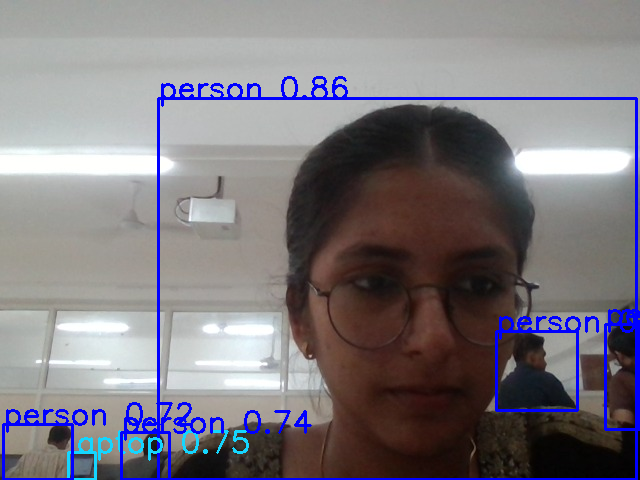


0: 480x640 5 persons, 1 laptop, 492.9ms
Speed: 5.1ms preprocess, 492.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


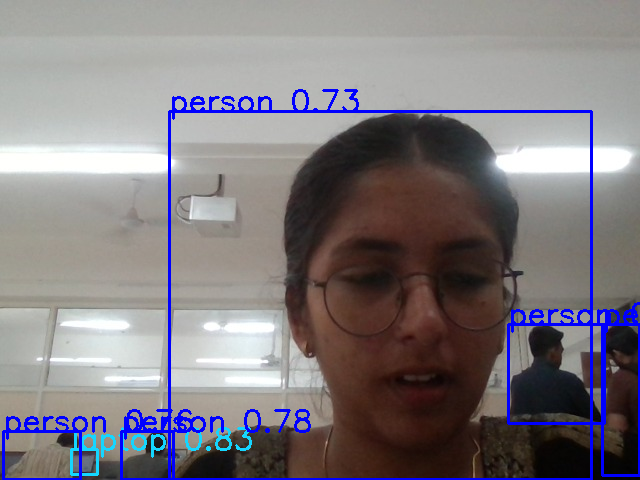


0: 480x640 5 persons, 1 laptop, 478.2ms
Speed: 4.9ms preprocess, 478.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


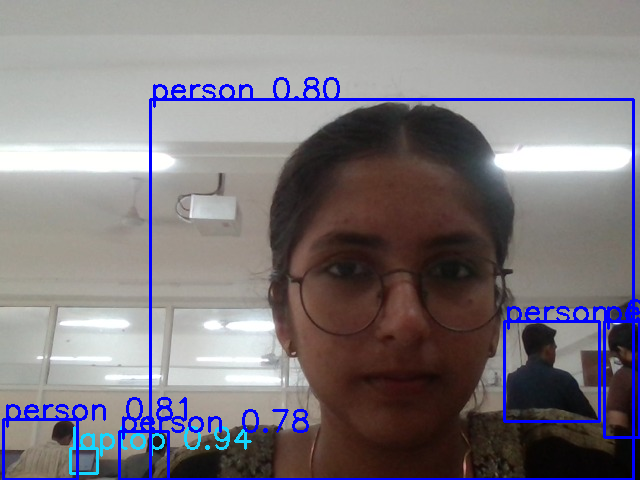


0: 480x640 3 persons, 1 laptop, 439.3ms
Speed: 2.9ms preprocess, 439.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


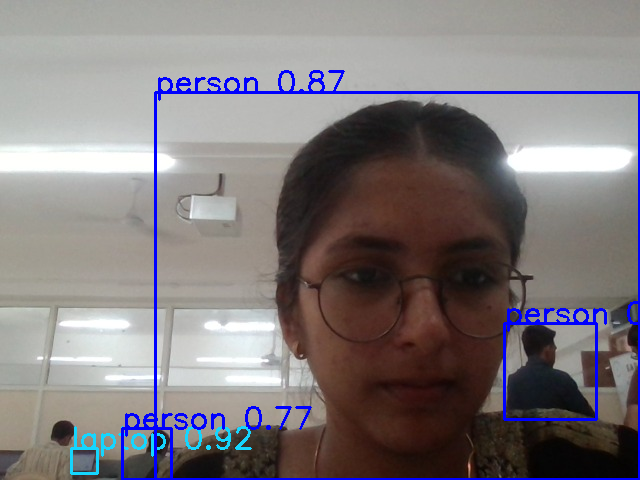


0: 480x640 4 persons, 1 laptop, 459.4ms
Speed: 4.6ms preprocess, 459.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


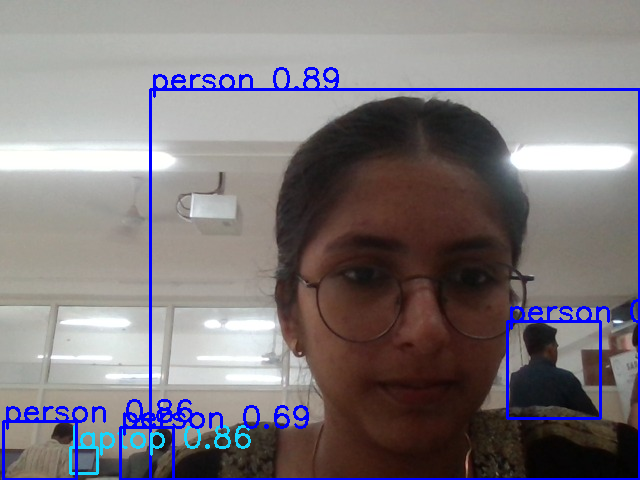


0: 480x640 4 persons, 1 laptop, 458.0ms
Speed: 2.8ms preprocess, 458.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


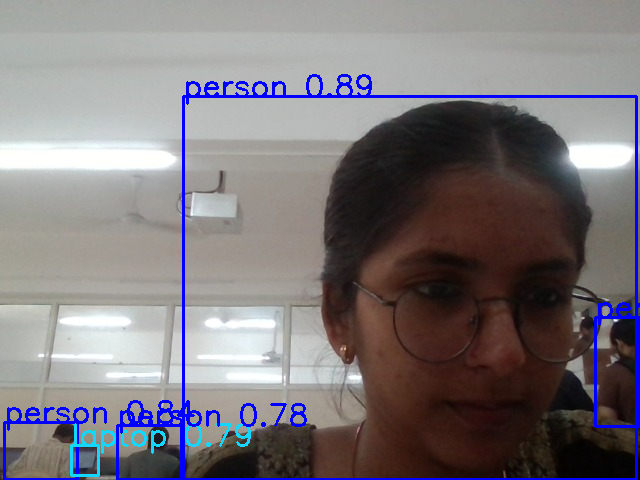


0: 480x640 5 persons, 1 laptop, 470.8ms
Speed: 4.6ms preprocess, 470.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


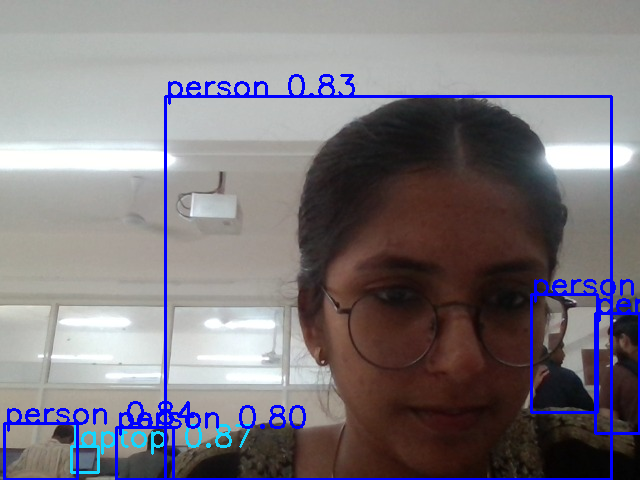


0: 480x640 5 persons, 1 laptop, 649.9ms
Speed: 4.7ms preprocess, 649.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


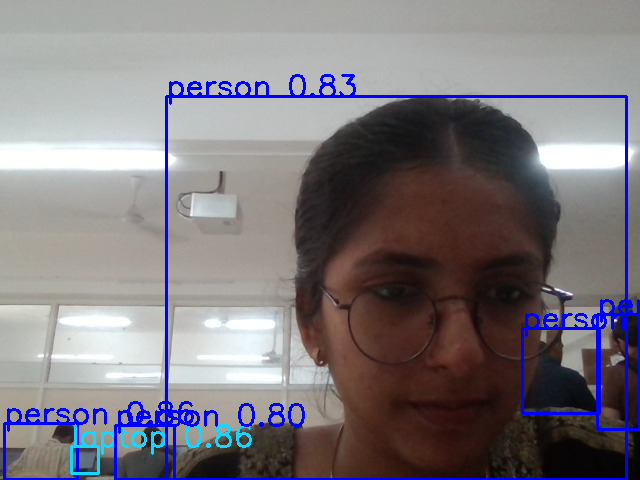


0: 480x640 3 persons, 1 laptop, 474.4ms
Speed: 3.7ms preprocess, 474.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


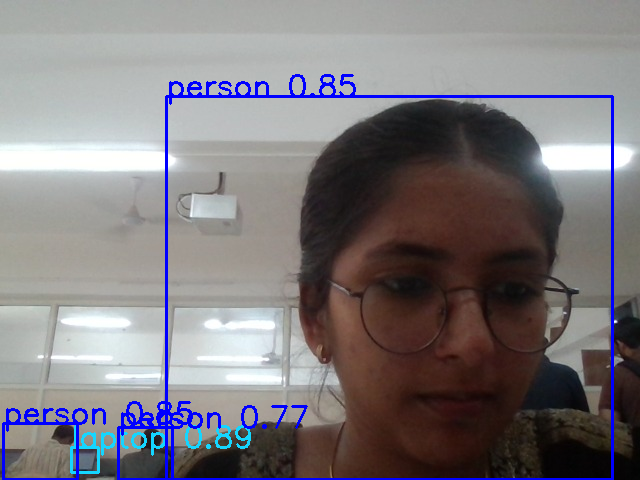

KeyboardInterrupt: 

In [5]:
# JavaScript code for capturing images
js_code = '''
function initCamera() {
    return new Promise((resolve, reject) => {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);
        const streamPromise = navigator.mediaDevices.getUserMedia({video: true});
        streamPromise.then((stream) => {
            video.srcObject = stream;
            video.onloadedmetadata = () => {
                resolve(video);
            };
            video.play();
        }).catch((error) => {
            reject(error);
        });
    });
}

async function takePhoto() {
    const video = await initCamera();
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const img = canvas.toDataURL('image/jpeg');
    return img;
}
'''

# Execute JavaScript code
display(Javascript(js_code))

# Function to convert base64 image to OpenCV format
def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image_PIL = Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image_PIL)
    frame = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return frame

# Load the YOLO model
yolo = YOLO('yolov8s.pt')

# Function to get class colors
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] *
    (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)

while True:
    # Capture image from the webcam
    js_reply = eval_js('takePhoto()')
    frame = js_to_image(js_reply)

    if frame is None:
        continue

    results = yolo.track(frame, stream=True)

    for result in results:
        # get the classes names
        classes_names = result.names

        # iterate over each box
        for box in result.boxes:
            # check if confidence is greater than 40 percent
            if box.conf[0] > 0.4:
                # get coordinates
                [x1, y1, x2, y2] = box.xyxy[0]
                # convert to int
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # get the class
                cls = int(box.cls[0])

                # get the class name
                class_name = classes_names[cls]

                # get the respective colour
                colour = getColours(cls)

                # draw the rectangle
                cv2.rectangle(frame, (x1, y1), (x2, y2), colour, 2)

                # put the class name and confidence on the image
                cv2.putText(frame, f'{classes_names[int(box.cls[0])]} {box.conf[0]:.2f}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 2)

    # show the image
    cv2_imshow(frame)

    # break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the video capture and destroy all windows
cv2.destroyAllWindows()